In [1]:
import openai
from openai.types import Completion, CompletionChoice, CompletionUsage
import os
import requests
from dotenv import load_dotenv
from scipy.optimize import minimize, Bounds, NonlinearConstraint
from functools import partial 
from scipy.spatial import Voronoi, voronoi_plot_2d, ConvexHull
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
from matplotlib.path import Path
from shapely import Polygon, Point

load_dotenv("/Users/gabriellelittlefair/Documents/GitHub/MSc Project/DSL/hidden.env")
%reload_ext autoreload
from Setup_Functions import *
from Class_Structures import *
from Region import * 
from Individual import * 
from InterObject import * 
from Global import * 

No region with this name is in the room.
Region not found.
No region with this name is in the room.
Region not found.
No region with this name is in the room.
Region not found.
No region with this name is in the room.
Region not found.
No region with this name is in the room.
Region not found.
No region with this name is in the room.
Region not found.
No region with this name is in the room.
Region not found.
No region with this name is in the room.
Region not found.


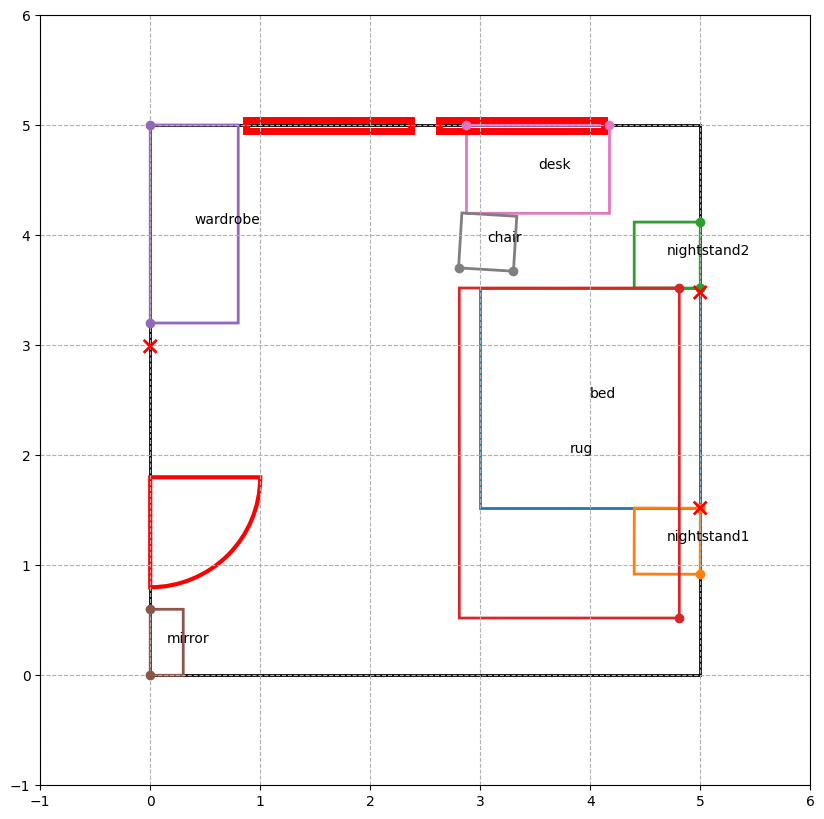

In [2]:
room = create_room(5, 5)
create_fixed_object(room, 'window', 1.5, 0.1, 'north', position = 0.25)
create_fixed_object(room, 'window', 1.5, 0.1, 'north', position = 0.75)
create_fixed_object(room, 'door', 1, 0.1, 'west', position = 0.2)
create_fixed_object(room, 'socket', 0.1, 0.05, 'west', position = 0.6)
create_fixed_object(room, 'socket', 0.1, 0.05, 'east', position = 0.3)
create_fixed_object(room, 'socket', 0.1, 0.05, 'east', position = 0.7)

create_moving_object(room, 'bed', 2, 2, 'sleeping', 0)
create_moving_object(room, 'nightstand1', 0.6, 0.6, 'sleeping', 1)
create_moving_object(room, 'nightstand2', 0.6, 0.6, 'sleeping', 2)
create_moving_object(room, 'rug', 3, 2, 'sleeping', 3)
create_moving_object(room, 'wardrobe', 1.8, 0.8, 'storage/dressing', 4)
create_moving_object(room, 'mirror', 0.6, 0.3, 'storage/dressing', 5)
create_moving_object(room, 'desk', 1.3, 0.8, 'working', 6)
create_moving_object(room, 'chair', 0.5, 0.5, 'working', 7)

# room.moving_objects[0].position = [3.99999993, 2.01999815, 1.57079625]
# room.moving_objects[1].position = [4.70000764, 0.71935632, 1.56844244]
# room.moving_objects[2].position = [4.70000001, 3.32000331, 1.57078561]

room.moving_objects[0].position = [3.99999993, 3.01999815 - 0.5, 1.57079625]
room.moving_objects[1].position = [4.70000764, 1.71935632 - 0.5, 1.56844244]
room.moving_objects[2].position = [4.70000001, 4.32000331 - 0.5, 1.57078561]

room.moving_objects[3].position = [3.80960429, 2.02034731, 1.57089316]
room.moving_objects[4].position =  [0.39999812, 4.10251161, 4.71239135]
room.moving_objects[5].position = [0.1500043,  0.29999365, 4.71240409]
room.moving_objects[6].position = [3.52519253, 4.6000121,  3.14158343]
room.moving_objects[7].position = [ 3.06766335,  3.93811213, -0.06065314]

room.draw()


In [3]:
### new plot/representation (points for the edges of the objects, and then try find medial axis)

def medial_axis(room, draw = False):

    final_points = []

    # Draw the room
    rect = patches.Rectangle((0, 0), room.width, room.length, linewidth=2, edgecolor='black', facecolor='none', label='_nolegend_')

    points = []
    cs = rect.get_corners()
    num_points = int(np.ceil(2 * (5 * room.width + 5 * room.length)))
    for i in range(num_points):
        points.append(cs[0] + (cs[1] - cs[0]) * i / num_points)  # Bottom side
        points.append(cs[1] + (cs[2] - cs[1]) * i / num_points)  # Right side
        points.append(cs[2] + (cs[3] - cs[2]) * i / num_points)  # Top side
        points.append(cs[3] + (cs[0] - cs[3]) * i / num_points)  # Left side
    final_points.append(points)

    rug_names = ['rug', 'mat', 'Rug', 'Mat', 'RUG', 'MAT', 'carpet', 'Carpet']
    # Draw the objects
    if room.moving_objects:
        for obj in room.moving_objects:
            rug = False
            for name in rug_names: 
                if name in obj.name:
                    rug = True
                    break
            if rug: 
                continue 
            cs_tup = obj.corners()
            cs = [np.array(i) for i in cs_tup]
            points = []
            num_points = int(np.ceil(2 * (5 * obj.width + 5 * obj.length)))
            for i in range(num_points):
                points.append(cs[0] + (cs[1] - cs[0]) * i / num_points)  # Bottom side
                points.append(cs[1] + (cs[2] - cs[1]) * i / num_points)  # Right side
                points.append(cs[2] + (cs[3] - cs[2]) * i / num_points)  # Top side
                points.append(cs[3] + (cs[0] - cs[3]) * i / num_points)  # Left side
            
            points = np.array(points)
            final_points.append(points)

    if room.fixed_objects:
        for obj in room.fixed_objects:
            if obj.name == 'door':

                wedge = patches.Wedge(center=obj.position[:2], r=obj.width, 
                                        theta1=np.rad2deg(obj.position[2]), theta2=np.rad2deg(obj.position[2]) + 90, linewidth=3, edgecolor='r', facecolor='none')
                
                points = wedge.get_path().vertices
                if obj.position[2] == 0:
                    points = [i for i in points if np.isclose(i[1], 0)]
                    points = np.unique(points, axis = 0)
                    min_x, max_x = sorted([i[0] for i in points])
                    crit = lambda x: np.isclose(x[1], 0) and (min_x < x[0]) and (x[0] < max_x)
                    crit2 = lambda x: np.isclose(x[1], 0)
                elif obj.position[2] == np.pi/2:
                    points = [i for i in points if np.isclose(i[0], room.width)]
                    points = np.unique(points, axis = 0)
                    min_y, max_y = sorted([i[1] for i in points])
                    crit = lambda x: np.isclose(x[0], room.width) and( min_y < x[1]) and (x[1] < max_y ) 
                    crit2 = lambda x: np.isclose(x[0], room.width) 
                elif obj.position[2] == np.pi:
                    points = [i for i in points if np.isclose(i[1], room.length)]
                    points = np.unique(points, axis = 0)
                    min_x, max_x = sorted([i[0] for i in points])
                    crit = lambda x: np.isclose(x[1], room.length) and (min_x < x[0]) and (x[0] < max_x)
                    crit2 = lambda x: np.isclose(x[1], room.length)
                elif obj.position[2] == 3*np.pi/2:
                    points = [i for i in points if np.isclose(i[0], 0)]
                    points = np.unique(points, axis = 0)
                    min_y, max_y = sorted([i[1] for i in points])
                    crit = lambda x: np.isclose(x[0], 0) and (min_y < x[1]) and (x[1] < max_y ) 
                    crit2 = lambda x: np.isclose(x[0], 0)
                final_points.append(points)

    final_points = np.concatenate(final_points)

    door_points = []
    for point in final_points:
        if crit(point):
            door_points += [point]
            final_points = np.delete(final_points, np.where(np.all(final_points == point, axis = 1)), axis = 0)
    vor = Voronoi(final_points)

    new_edges = []
    new_ridge_points = []
    max_distances = []

    ## find the door ridge 
    ridge_points = vor.ridge_points
    for i in range(len(ridge_points)): 
        edge = ridge_points[i]
        p1, p2 = vor.points[edge]
        if crit2(p1) and crit2(p2) and np.linalg.norm(p1 - p2) > 0.4:
            new_edges.append(vor.ridge_vertices[i])
            new_ridge_points.append(vor.ridge_points[i])

    for i in range(len(vor.ridge_vertices)): 
        edge = vor.ridge_vertices[i]
        remove = False
        p1 = vor.vertices[edge[0]]
        p2 = vor.vertices[edge[1]]
        if (edge[0] == -1 or edge[1] == -1):
            continue
        if p1[0] < 0 or p2[0] < 0 or p1[1] < 0 or p2[1] < 0:
            continue
        if p1[0] > room.width or p1[1] > room.length or p2[0] > room.width or p2[1] > room.length:
            continue
        for obj in room.moving_objects:
            rug = False
            for name in rug_names: 
                if name in obj.name:
                    rug = True
                    break
            if rug:
                continue
            poly = Polygon(obj.corners())
            if any([poly.contains(Point(vor.vertices[v])) for v in edge]):
                remove = True
                break

        if remove: 
            continue
        

        regions = [j for j in range(len(vor.regions)) if edge[0] in vor.regions[j] and edge[1] in vor.regions[j]]
        region_vs = [[], []]
        for j in range(2): 
            region_vs[j] = [v for v in vor.regions[regions[j]] if v != edge[0] and v != edge[1]]

        dists = []
        for j in range(len(region_vs[0])): 
            for k in range(len(region_vs[1])):
                dists.append(np.linalg.norm(vor.vertices[region_vs[0][j]] - vor.vertices[region_vs[1][k]]))
        if np.any(np.array(dists) < 1e-8): 
            continue 
        else: 
            max_distances.append(np.min(dists))
            new_edges.append(edge)  
            new_ridge_points.append(vor.ridge_points[i])  

    new_vor = Voronoi(final_points)
    new_vor.vertices = vor.vertices
    new_vor.regions = vor.regions
    new_vor.ridge_vertices = new_edges
    new_vor.ridge_points = new_ridge_points

    if draw:
        fig, ax = plt.subplots(figsize = (10, 10))
        voronoi_plot_2d(new_vor, ax=ax, show_points=True, show_vertices=False, line_colors='gray')

    return new_vor, max_distances

vor, ds = medial_axis(room)


510 510


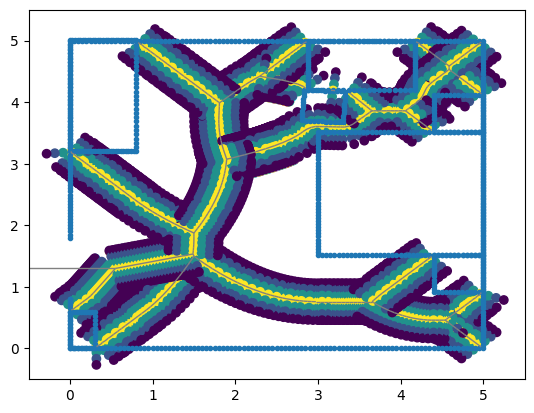

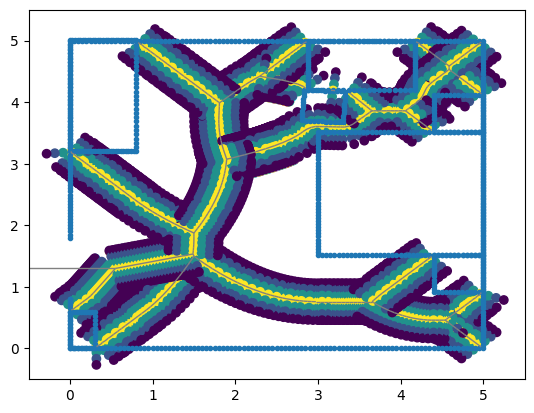

In [4]:
points1 = []
points2 = []
all_points = []
weights = []

print(len(vor.ridge_points), len(vor.ridge_vertices))
fig, axes = plt.subplots()
for i in range(len(vor.ridge_vertices)): 
    mid_points = []
    edge = vor.ridge_vertices[i]
    point_edge = vor.ridge_points[i]
    if np.linalg.norm(vor.vertices[edge[0]] - vor.vertices[edge[1]]) > 0.1: 
        points = np.linspace(vor.vertices[edge[0]], vor.vertices[edge[1]], 25)
        verts = [i.tolist() for i in vor.vertices]
        vor.vertices = np.array(verts + points.tolist())
        mid_points = points

    min_index = np.argmin([vor.vertices[edge[0]][0], vor.vertices[edge[1]][0]])
    other_index = 1 - min_index
    direction = vor.vertices[edge[other_index]] - vor.vertices[edge[min_index]]
    direction = direction / np.linalg.norm(direction)
    perpendicular_direction = np.array([direction[1], -direction[0]])
    perpendicular_direction = perpendicular_direction / np.linalg.norm(perpendicular_direction)

    ws = np.array([1, 2, 3, 5, 3, 2, 1])/7
    if len(mid_points) > 0: 
        for point in mid_points: 
            mid_point = point
            x = np.linspace(mid_point[0] - 0.3 * perpendicular_direction[0], mid_point[0] + 0.3 * perpendicular_direction[0], 7)
            y = np.linspace(mid_point[1] - 0.3 * perpendicular_direction[1], mid_point[1] + 0.3 * perpendicular_direction[1], 7)
            for i in range(7): 
                all_points.append([x[i], y[i]])
            axes.scatter(x, y)
    else: 
        mid_point = (vor.vertices[edge[0]] + vor.vertices[edge[1]]) / 2
        val = False
        for point in vor.points: 
            if np.linalg.norm(point - mid_point) < 0: 
                val = True
                break
        if val: 
            continue

        x = np.linspace(mid_point[0] - 0.3 * perpendicular_direction[0], mid_point[0] + 0.3 * perpendicular_direction[0], 7)
        y = np.linspace(mid_point[1] - 0.3 * perpendicular_direction[1], mid_point[1] + 0.3 * perpendicular_direction[1], 7)
        for xi, yi in zip(x, y):
            all_points.append([xi, yi])
        
all_points = np.array(all_points)
weights = ws.tolist() * (all_points.shape[0]//7)
axes.scatter(all_points[:, 0], all_points[:, 1], c = weights)
voronoi_plot_2d(vor, ax = axes, show_points=True, show_vertices=False, line_colors='gray')

In [5]:
def find_corners(points): 

    c_inds =[]
    neighbour_inds = []
    for i in range(points.shape[0]): 
        dists = np.linalg.norm(points - points[i], axis = 1)
        inds = [j for j in np.where(dists < 0.15)[0] if j != i]
        neighbours = points[inds]
        ds = []
        for n in neighbours:
            direction = n - points[i]
            if np.isnan(direction[0]/np.linalg.norm(direction)) or np.isnan(direction[1]/np.linalg.norm(direction)):
                continue
            ds += [direction / np.linalg.norm(direction)]
        for j in range(len(ds) - 1): 
            angles = np.arccos(np.dot(ds[j+1:], ds[j]))
            if (np.any(np.isclose(angles, np.pi/2)) or np.any(np.isclose(angles, -np.pi/2))):
                # if (np.any(np.isclose(angles, np.pi, rtol = 0.4)) or np.any(np.isclose(angles, -np.pi, rtol = 0.4))):
                neighbour_inds += [inds]
                c_inds.append(i)
                break
    
    copy_inds = c_inds.copy()
    for ind in range(len(copy_inds)): 
        num = 0
        new_ind = copy_inds[ind]
        neighbours = points[neighbour_inds[ind]]
        diff = (neighbours - points[new_ind])/np.linalg.norm(points[new_ind] - neighbours, axis = 1)[:, None]
        for i in range(diff.shape[0]): 
            new_diff = np.dot(np.concatenate([diff[:i], diff[i + 1:]]), diff[i])
            if not np.any(new_diff < -0.9):
                num += 1
        if num == len(neighbours): 
            c_inds.remove(new_ind)
    
    corner1 = np.argmin(points[:, 0] + points[:, 1])
    corner2 = np.argmax(points[:, 0] + points[:, 1])
    corner3 = np.argmax(points[:, 0] - points[:, 1])
    corner4 = np.argmin(points[:, 0] - points[:, 1])
    if corner1 not in c_inds: 
        c_inds.append(corner1)
    if corner2 not in c_inds:
        c_inds.append(corner2)
    if corner3 not in c_inds:
        c_inds.append(corner3)
    if corner4 not in c_inds:
        c_inds.append(corner4)

    return c_inds



def path_points(room): 

    vor, _ = medial_axis(room)
    vor_points = vor.points
    all_points = []
    weights = []
    mps = []

    c_inds = find_corners(vor_points)
    corner_points = vor_points[c_inds]

    fig, axes = plt.subplots()
    for i in range(len(vor.ridge_vertices)): 
        mid_points = []
        edge = vor.ridge_vertices[i]
        if np.linalg.norm(vor.vertices[edge[0]] - vor.vertices[edge[1]]) > 0.1: 
            points = np.linspace(vor.vertices[edge[0]], vor.vertices[edge[1]], 25)
            verts = [i.tolist() for i in vor.vertices]
            vor.vertices = np.array(verts + points.tolist())
            mid_points = points

        min_index = np.argmin([vor.vertices[edge[0]][0], vor.vertices[edge[1]][0]])
        other_index = 1 - min_index
        direction = vor.vertices[edge[other_index]] - vor.vertices[edge[min_index]]
        direction = direction / np.linalg.norm(direction)
        perpendicular_direction = np.array([direction[1], -direction[0]])
        perpendicular_direction = perpendicular_direction / np.linalg.norm(perpendicular_direction)


        ws =np.array([1, 2, 3, 5, 3, 2, 1])
        if len(mid_points) > 0: 
            for point in mid_points: 
                mps += [point]
                mid_point = point
                dists = np.linalg.norm(corner_points - mid_point, axis = 1)
                if np.any(dists < 0.25): 
                    continue
                x = np.linspace(mid_point[0] - 0.3 * perpendicular_direction[0], mid_point[0] + 0.3 * perpendicular_direction[0], 7)
                y = np.linspace(mid_point[1] - 0.3 * perpendicular_direction[1], mid_point[1] + 0.3 * perpendicular_direction[1], 7)
                for i in range(7): 
                    all_points.append([x[i], y[i]])
                axes.scatter(x, y)
        else: 
            
            mid_point = (vor.vertices[edge[0]] + vor.vertices[edge[1]]) / 2
            dists = np.linalg.norm(corner_points - mid_point, axis = 1)
            if np.any(dists < 0.25): 
                continue
            mps += [mid_point]
            val = False
            for point in vor.points: 
                if np.linalg.norm(point - mid_point) < 0: 
                    val = True
                    break
            if val: 
                continue

            x = np.linspace(mid_point[0] - 0.3 * perpendicular_direction[0], mid_point[0] + 0.3 * perpendicular_direction[0], 7)
            y = np.linspace(mid_point[1] - 0.3 * perpendicular_direction[1], mid_point[1] + 0.3 * perpendicular_direction[1], 7)
            for xi, yi in zip(x, y):
                all_points.append([xi, yi])
        
            
    all_points = np.array(all_points)
    weights = ws.tolist() * (all_points.shape[0]//7)
    mps = np.array(mps)

    inds = []
    for i in range(mps.shape[0]):
        point = mps[i]
        dists = np.linalg.norm(corner_points - point, axis = 1)
        if np.all(dists > 0.1):
            inds += [i]
    
    mps = mps[inds]


    axes.scatter(all_points[:, 0], all_points[:, 1], c = weights)
    voronoi_plot_2d(vor, ax = axes, show_points=True, show_vertices=False, line_colors='gray')

    return all_points, weights, mps


def cost(positions, room, points, weights): 

    intersection = 0
    rug_names = ['rug', 'mat', 'Rug', 'Mat', 'RUG', 'MAT', 'carpet', 'Carpet']
    for i in range(len(room.moving_objects)): 
        rug = False
        for name in rug_names: 
            if name in room.moving_objects[i].name:
                rug = True
                break
        if rug: 
            continue 
        x, y, theta = get_position(positions, room, i)
        cs = corners(x, y, theta, room.moving_objects[i].width, room.moving_objects[i].length)
        poly = Polygon(cs)
        for j in range(points.shape[0]): 
            if poly.contains(Point(points[j, :])): 
                intersection += weights[j]*poly.exterior.distance(Point(points[j, :]))**2

    return intersection
            

/var/folders/25/n8z44f7d4tn9463r4xj1ncv00000gn/T/ipykernel_88123/3084386369.py:16: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(np.dot(ds[j+1:], ds[j]))


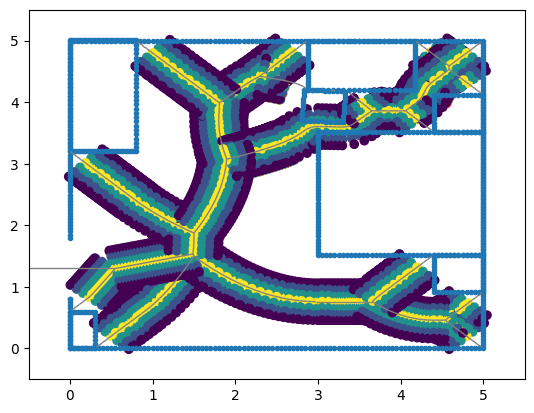

In [6]:
positions = np.zeros(len(room.moving_objects)*3)
for i in range(len(room.moving_objects)): 
    positions[3*i] = room.moving_objects[i].position[0]
    positions[3*i + 1] = room.moving_objects[i].position[1]
    positions[3*i + 2] = room.moving_objects[i].position[2]

points, weights= room.path_points()
#cost(positions, room, points, weights)

/var/folders/25/n8z44f7d4tn9463r4xj1ncv00000gn/T/ipykernel_88123/3084386369.py:16: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(np.dot(ds[j+1:], ds[j]))


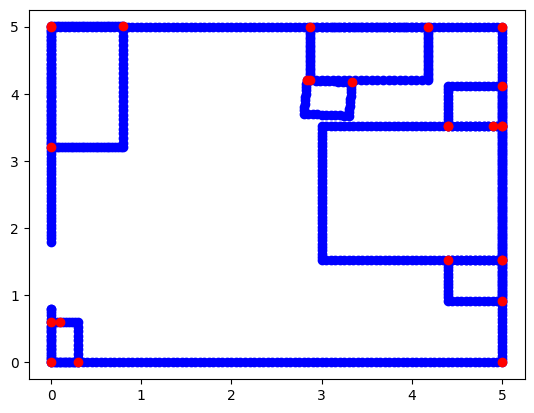

In [7]:
c_inds = find_corners(vor.points)
plt.scatter(vor.points[:, 0], vor.points[:, 1], c = 'b')
plt.scatter(vor.points[c_inds, 0], vor.points[c_inds, 1], c = 'r')

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.022710689344185995
            Iterations: 17
            Function evaluations: 433
            Gradient evaluations: 17


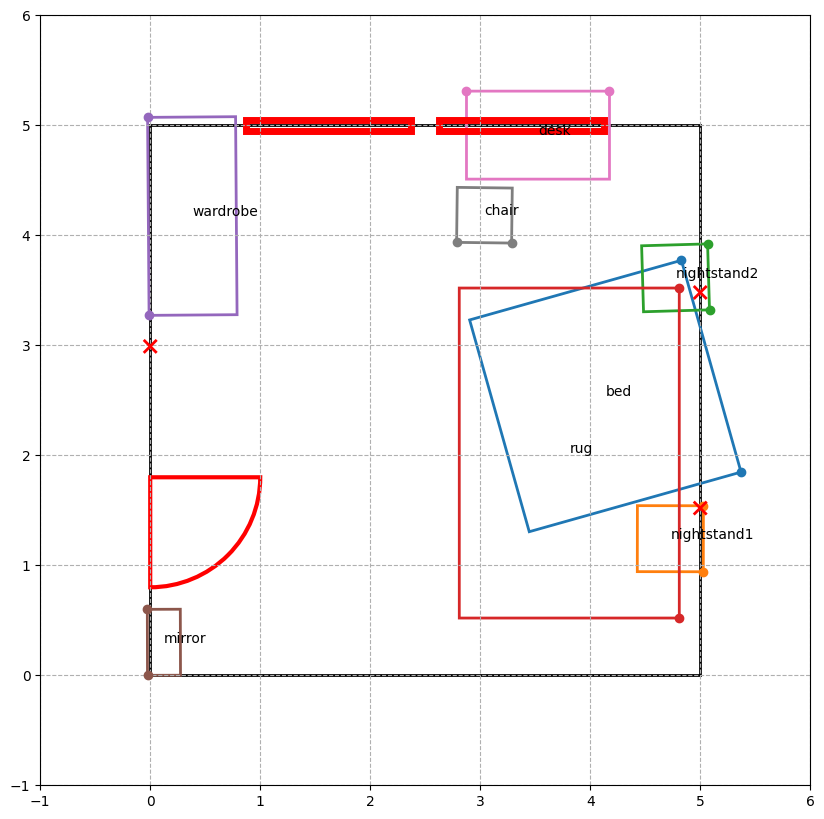

In [8]:
for i in range(len(room.moving_objects)): 
    positions[3*i] = room.moving_objects[i].position[0]
    positions[3*i + 1] = room.moving_objects[i].position[1]
    positions[3*i + 2] = room.moving_objects[i].position[2]

options = {'maxiter': 50, 'disp': True}
bounds = Bounds([-10] * 3 * len(room.moving_objects), [room.width + 10, room.length + 10, np.Inf] * len(room.moving_objects))

res = minimize(cost, positions, args = (room, points, weights), method = 'SLSQP', options = options, bounds = bounds)

for i in range(len(room.moving_objects)):
    room.moving_objects[i].position = [res.x[3*i], res.x[3*i + 1], res.x[3*i + 2]]

room.draw()

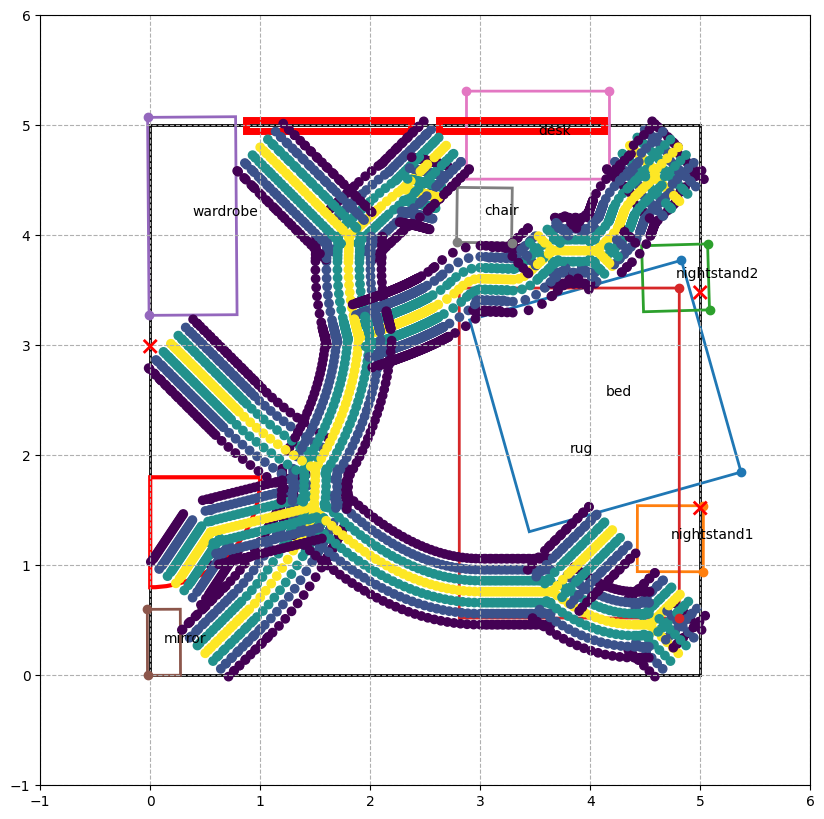

In [9]:
draw_medial_axis(room, points, weights)